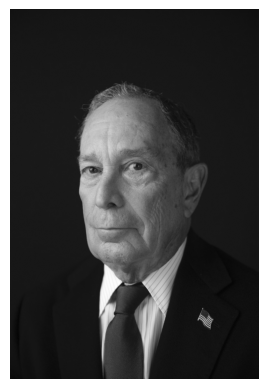

In [149]:
from PIL import Image
import utils

# Open the image file
img = Image.open('bloomberg.jpg')

# Convert the image to grayscale
gray_img = img.convert('L')

# Display the grayscale image
import matplotlib.pyplot as plt

# Display the grayscale image in the notebook
plt.imshow(gray_img, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

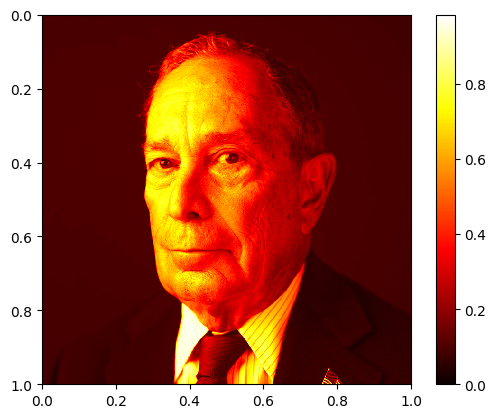

In [150]:
import torch

import torchvision.transforms as transforms

# Define a transform to convert the image to a tensor
transform = transforms.ToTensor()

# Apply the transform to the grayscale image
tensor_img = transform(gray_img)

# Squeeze the tensor to remove the single-dimensional entries
img_surface = torch.squeeze(tensor_img, 0)


def center_crop_square(img: torch.Tensor) -> torch.Tensor:
    h, w = img.shape
    size = min(h, w)  # target square size
    top = (h - size) // 2
    left = (w - size) // 2

    return img[top:top+size, left:left+size]

img_surface = center_crop_square(img_surface)
utils.print_tensor(img_surface)

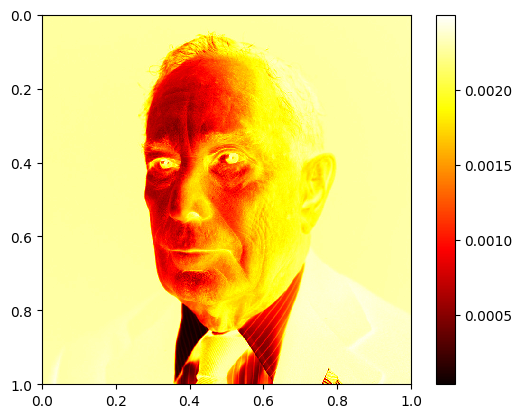

In [151]:
# Invert the image, for ball dynamic

img_surface = 1 - img_surface
img_surface = img_surface / 400
utils.print_tensor(img_surface)

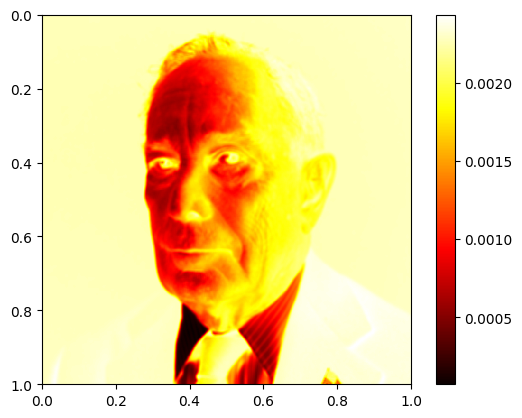

In [152]:
# apply gaussian filter
from torchvision.transforms import GaussianBlur

blur = GaussianBlur(kernel_size=7, sigma=(4.0, 10.0))
img_surface = blur(img_surface.unsqueeze(0)).squeeze(0)
utils.print_tensor(img_surface)

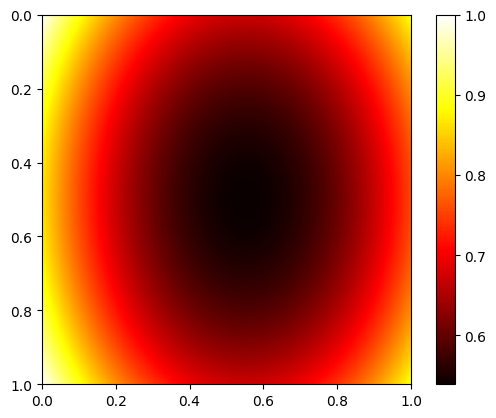

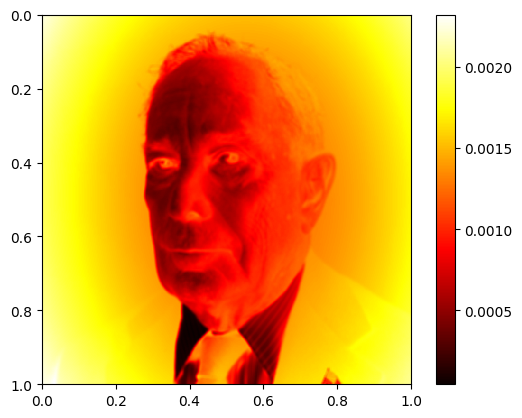

In [153]:
# apply a mask to prevent gradient deadzones
H, W = img_surface.shape
assert H == W
ys = torch.linspace(0, 1, H)
xs = torch.linspace(0, 1, W)
X, Y = torch.meshgrid(xs, ys, indexing="xy")

gradient_filter = utils.normalize_tensor(utils.f_paraboloid(X, Y) + 0.5)
# gradient_filter = torch.clamp(gradient_filter, )
utils.print_tensor(gradient_filter)
utils.print_tensor(img_surface * gradient_filter)

In [154]:
img_surface *= gradient_filter

Ball position: (0.52, 0.38)


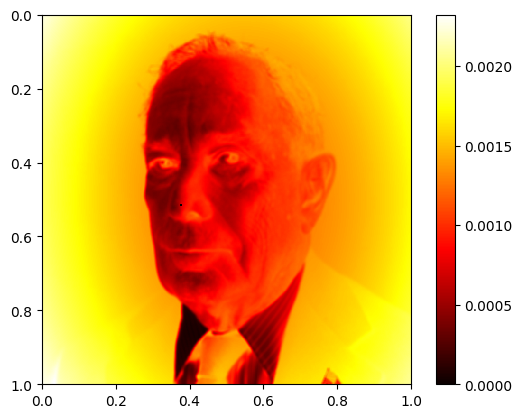

In [155]:
# Define a point within the bounds of the squeezed tensor image
ball_position = (0.52, 0.38)
print(f"Ball position: {ball_position}")
marked_img = utils.mark_point_on_tensor(img_surface, ball_position, slice_size=0.02)
utils.print_tensor(marked_img)

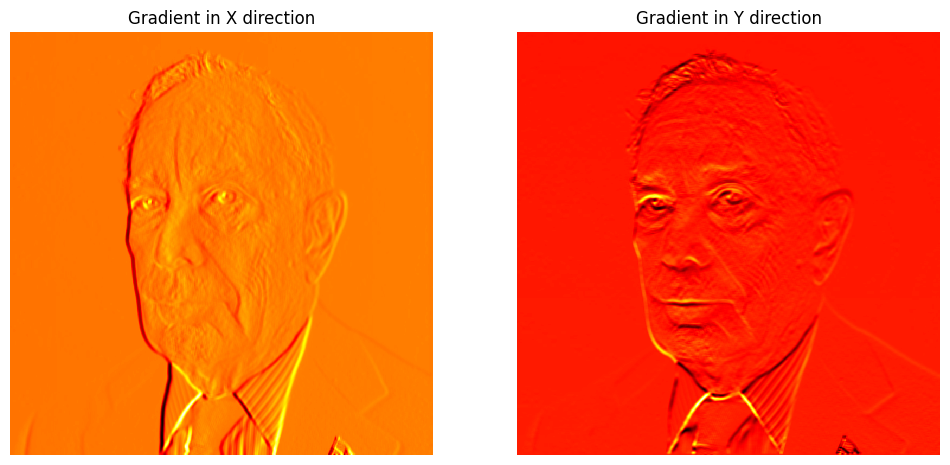

In [156]:
H, W = img_surface.shape
assert H == W
# Calculate the gradient of the squeezed tensor image
gradient_x, gradient_y = utils.get_grads(img_surface, H, W)


# Display the gradients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(gradient_x.numpy(), cmap='hot', interpolation='nearest')
ax1.set_title('Gradient in X direction')
ax1.axis('off')

ax2.imshow(gradient_y.numpy(), cmap='hot', interpolation='nearest')
ax2.set_title('Gradient in Y direction')
ax2.axis('off')

plt.show()

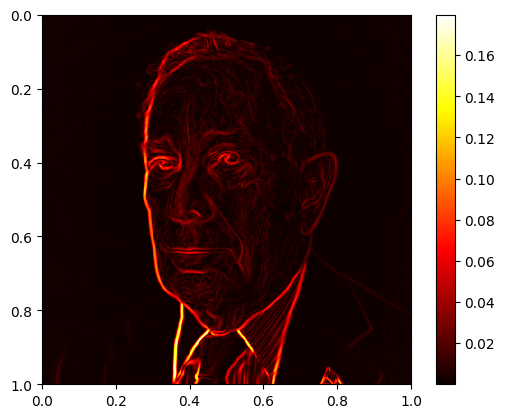

In [157]:
mag_grad = torch.sqrt(gradient_x ** 2 + gradient_y ** 2)
utils.print_tensor(mag_grad)

In [158]:
Z = img_surface
# Initial parameters
NUM_ITER = 1000*2*5*3*10*5
# NUM_ITER = 10
position_of_ball = torch.tensor(ball_position[::-1])
velocity = torch.tensor([1.0, 1.0]) * 0.00001 * 2
position_over_iterations_raw = [position_of_ball.clone()]
velocity_mag_over_time_raw = [torch.norm(velocity, p=2)]

x_slopes, y_slopes = utils.get_grads(Z, H, W)
def get_at_x_y(x, y):
    coords = int(y * W), int(x * H)
    return x_slopes[*coords], y_slopes[*coords]


for i in range(NUM_ITER):
    try:
        x_slope, y_slope = get_at_x_y(position_of_ball[0], position_of_ball[1])
        x_acc_comp, _, _ = utils.get_acceleration_right_triangle_slope(x_slope)
        y_acc_comp, _, _, = utils.get_acceleration_right_triangle_slope(y_slope)
        acceleration = torch.stack((x_acc_comp, y_acc_comp))
        velocity += acceleration
        position_of_ball += velocity
        for i in (0, 1):
            if position_of_ball[i] >= 1:
                position_of_ball -= velocity
                velocity[i] *= -1
        assert torch.all((position_of_ball >= 0) & (position_of_ball < 1)), "Tensor elements are not all between 0 and 1"
        position_over_iterations_raw.append(position_of_ball.clone())
        velocity_mag_over_time_raw.append(torch.norm(velocity, p=2))
    except Exception as e:
        print("Broke at: ", i)
        print(e)
        break


In [159]:
position_over_iterations = torch.stack(position_over_iterations_raw)
velocity_mag_over_time = torch.stack(velocity_mag_over_time_raw) * 90 * 10 * 8 # * 200 * 100
print(velocity_mag_over_time)
# utils.print_list_numbers(list(velocity_mag_over_time))



tensor([0.2036, 0.2036, 0.2035,  ..., 0.1370, 0.1370, 0.1370])


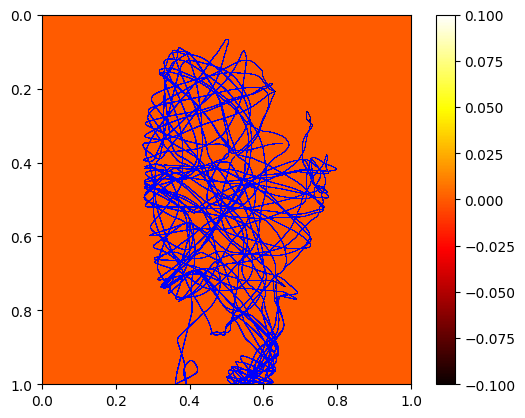

In [164]:
utils.print_tensor(Z * 0, position_over_iterations, ball_sizes=velocity_mag_over_time ** 1.5)

In [161]:
# todo: ball step size not linked to speed (fixed)